<a href="https://colab.research.google.com/github/applejxd/colaboratory/blob/master/OpenCvCalibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

このノートのプログラムは ["カメラキャリブレーション"](http://labs.eecs.tottori-u.ac.jp/sd/Member/oyamada/OpenCV/html/py_tutorials/py_calib3d/py_calibration/py_calibration.html) を利用

キャリブレーションに使う画像を用意

In [1]:
import urllib.request

base_url = 'https://raw.githubusercontent.com/opencv/opencv/master/samples/data/'

for i in range(1,15):
    if (i==10):
         continue
    num = str(i).zfill(2)
    file_name = 'left' + num + '.jpg'
    url = base_url + file_name
    urllib.request.urlretrieve(url, file_name)

画像処理の前準備としてチェスボードの点を指定する ndarray を作成

In [2]:
import numpy as np

# (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)

チェスボードコーナー検出

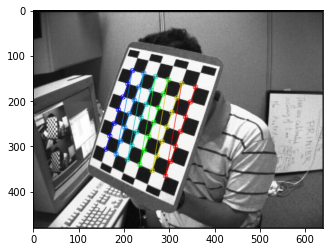

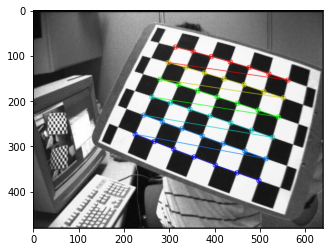

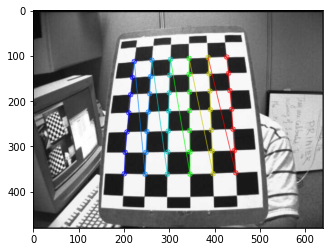

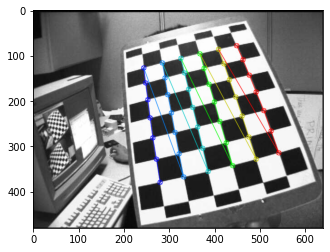

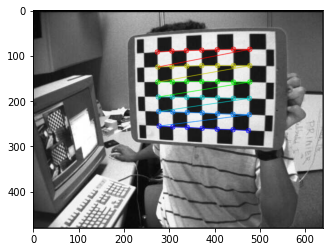

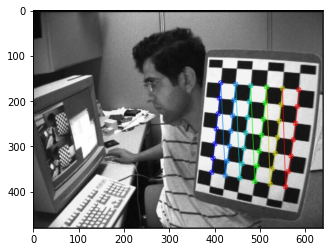

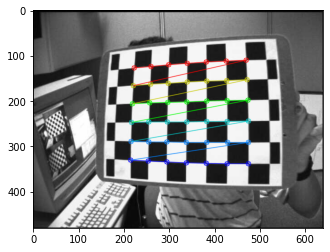

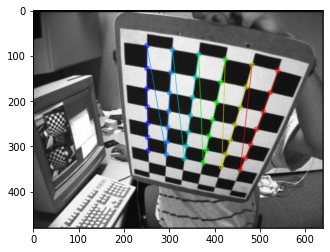

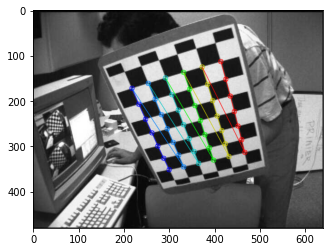

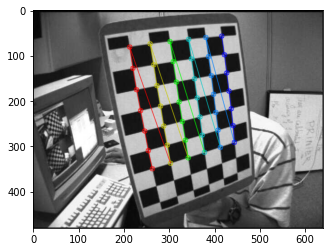

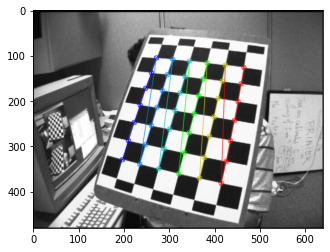

In [3]:
import cv2
import glob
import matplotlib.pyplot as plt

# 終了条件
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# 実際の3次元点
objpoints = [] 
# 画像平面上の2次元点
imgpoints = [] 

# ダウンロードした各画像を処理
images = glob.glob('*.jpg')
for fname in images:
    # 読み込んでグレースケールに変換
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # 7x6 のチェスボードコーナー検出
    ret, corners = cv2.findChessboardCorners(gray, (7,6), None)

    # 検出成功時
    if ret == True:
        # コーナー位置の高精度化（検索窓 23x23, 対象外領域なし）
        corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)

        objpoints.append(objp)
        imgpoints.append(corners2)

        # 7x6 のチェスボード描画
        img = cv2.drawChessboardCorners(img, (7,6), corners2, ret)
        plt.imshow(img)
        plt.show()

カメラ行列等を取得

In [13]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
    objpoints, imgpoints, gray.shape[::-1],None,None)
print(mtx)

[[534.07088623   0.         341.53407107]
 [  0.         534.11914798 232.94565221]
 [  0.           0.           1.        ]]


最適化された（補正後の）カメラ行列を取得

In [12]:
img = cv2.imread('left12.jpg')
h,  w = img.shape[:2]
newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))
print(newcameramtx)

[[458.64099121   0.         343.09157581]
 [  0.         457.19467163 233.83376475]
 [  0.           0.           1.        ]]


最短の歪み補正

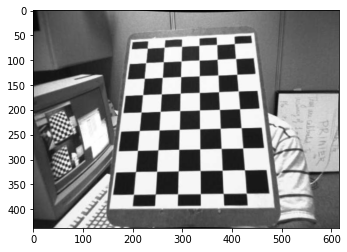

In [6]:
# undistort
dst = cv2.undistort(img, mtx, dist, None, newcameramtx)

# crop the image
x,y,w,h = roi
dst = dst[y:y+h, x:x+w]
plt.imshow(dst)
plt.show()

別の歪み補正

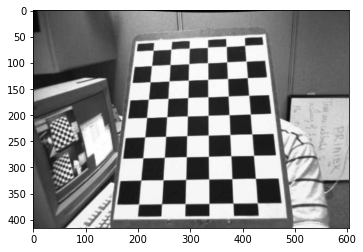

In [7]:
# undistort
mapx,mapy = cv2.initUndistortRectifyMap(mtx,dist,None,newcameramtx,(w,h),5)
dst = cv2.remap(img,mapx,mapy,cv2.INTER_LINEAR)

# crop the image
x,y,w,h = roi
dst = dst[y:y+h, x:x+w]
plt.imshow(dst)
plt.show()

キャリブレーションを評価

In [11]:
mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv2.norm(imgpoints[i],imgpoints2, cv2.NORM_L2)/len(imgpoints2)
    mean_error += error

print("total error: ", mean_error/len(objpoints))

total error:  0.023686004734391333
